Based on https://nextjournal.com/gkoehler/pytorch-mnist
About MNIST: hello world of image recognition (and ML), 70 000 images (28x28) of handwritten digits (0-9), grayscale (0-255), 60 000 training images, 10 000 test images, 10 classes (one per digit)
- PyTorch has dynamic computation graphs (vs. static in TF), meaning that the graph is generated on the fly, based on the actual operations performed on the data

## Imports

In [15]:
import torch
import torchvision

import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


## Hyperparameters

In [16]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000

# for the optimizer
learning_rate = 0.01
momentum = 0.5

log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False # disable cudnn for reproducibility (cuuDNN uses nondeterministic algorithms which can be disabled )

torch.manual_seed(random_seed)

## Load dataset

In [17]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data_example_02/', train=True, download=True, 
                               transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                                         torchvision.transforms.Normalize((0.1307,), (0.3081,))])),
    batch_size=batch_size_train, shuffle=True)

# 0.1307 and 0.3081 are the mean and std of the MNIST dataset (just use it as it is)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data_example_02/', train=False, download=True, 
                               transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                                         torchvision.transforms.Normalize((0.1307,), (0.3081,))])),
    batch_size=batch_size_test, shuffle=True)

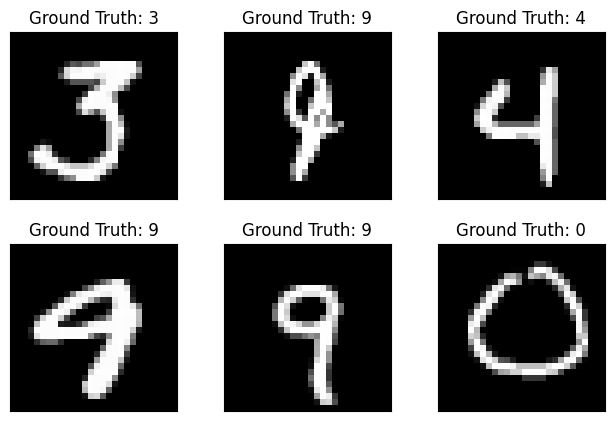

In [18]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape # Outputs: torch.Size([1000, 1, 28, 28]) -> 1000 images of 28x28 pixels (1 because no color channel)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])



## Neural network

In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) # 1 input channel, 10 output channels, 5x5 square convolution
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) # 10 input channel, 20 output channels, 5x5 square convolution
        self.conv2_drop = nn.Dropout2d() # dropout layer
        self.fc1 = nn.Linear(320, 50) # 320 input features, 50 output features
        self.fc2 = nn.Linear(50, 10) # 50 input features, 10 output features
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) # 2x2 max pooling
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) # 2x2 max pooling
        x = x.view(-1, 320) # flatten the tensor why? because the linear layer expects a 1D tensor
        x = F.relu(self.fc1(x)) # apply relu to the linear layer
        x = F.dropout(x, training=self.training) # apply dropout
        x = self.fc2(x) # apply the linear layer
        return F.log_softmax(x, dim=1) # apply log_softmax to the output of the linear layer
    
    # why log_softmax? because we are using the negative log likelihood loss (NLLLoss) and it expects log probabilities as input
    # why dropout? to avoid overfitting

In [20]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

# if using gpu for training uncomment the following lines
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# network.to(device)

## Training

In [21]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [22]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad() # zero the gradients
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward() # backpropagation
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss:{:.6f}'.format(
                epoch, batch_idx*len(data), len(train_loader.dataset),
                100.*batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), './results_example_02/model.pth')
            torch.save(optimizer.state_dict(), './results_example_02/optimizer.pth')
            # nn modules as well optimizers have a state_dict() method which returns a Python dictionary holding the complete state of the module
            

In [23]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad(): # avoid storing the computations done in the test phase (computational graph)
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy:{}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100.*correct / len(test_loader.dataset)))

In [24]:
test()
for epoch in range(1, n_epochs+1):
    train(epoch)
    test()

/home/martinsadric/pr-data-nns/pr-data-nns-venv/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3096, Accuracy:924/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss:2.313179
Train Epoch: 1 [640/60000 (1%)]	Loss:2.300776
Train Epoch: 1 [1280/60000 (2%)]	Loss:2.298872
Train Epoch: 1 [1920/60000 (3%)]	Loss:2.276723
Train Epoch: 1 [2560/60000 (4%)]	Loss:2.241102
Train Epoch: 1 [3200/60000 (5%)]	Loss:2.248662
Train Epoch: 1 [3840/60000 (6%)]	Loss:2.189547
Train Epoch: 1 [4480/60000 (7%)]	Loss:2.146399
Train Epoch: 1 [5120/60000 (9%)]	Loss:2.107701
Train Epoch: 1 [5760/60000 (10%)]	Loss:2.011356
Train Epoch: 1 [6400/60000 (11%)]	Loss:1.843857
Train Epoch: 1 [7040/60000 (12%)]	Loss:1.758839
Train Epoch: 1 [7680/60000 (13%)]	Loss:1.672644
Train Epoch: 1 [8320/60000 (14%)]	Loss:1.687645
Train Epoch: 1 [8960/60000 (15%)]	Loss:1.426628
Train Epoch: 1 [9600/60000 (16%)]	Loss:1.284204
Train Epoch: 1 [10240/60000 (17%)]	Loss:1.318824
Train Epoch: 1 [10880/60000 (18%)]	Loss:1.445287
Train Epoch: 1 [11520/60000 (19%)]	Loss:1.140686
Train Epoch: 1 [12160/60000 (20%)]	Loss:1.1

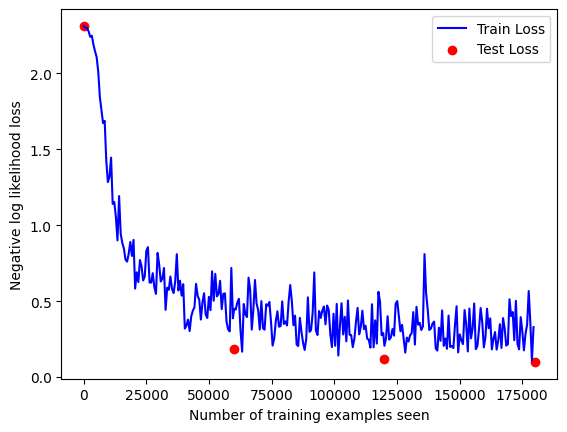

In [26]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('Number of training examples seen')
plt.ylabel('Negative log likelihood loss')
plt.show()

## Examples

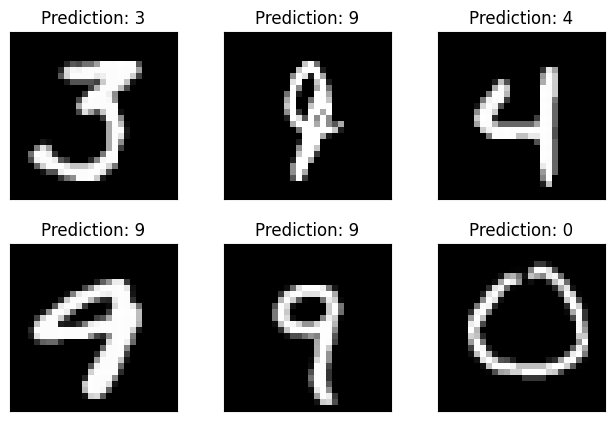

In [27]:
with torch.no_grad():
    output = network(example_data)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])